In [1]:
%cd ..

/home/eli/AnacondaProjects/epych


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import collections
import glob
import functools
import logging
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import quantities as pq

import epych
from epych.statistics import alignment

In [4]:
%matplotlib inline

In [5]:
logging.basicConfig(level=logging.INFO)

In [6]:
CONDITIONS = ["go_gloexp", "go_seqctl", "lo_gloexp", "lo_rndctl"]
PRETRIAL_SECONDS = 0.5
POSTTRIAL_SECONDS = 0.5

In [7]:
NWB_FILES = glob.glob('/mnt/data/*.nwb')

In [8]:
PILOT_FILES = []

In [9]:
NUM_TRIALS = 0
ODDBALL_ONSET = 0.
ODDBALL_OFFSET = 0.

In [10]:
evoked = {}

In [11]:
aligner = epych.statistics.alignment.AlignmentSummary.unpickle("/mnt/data/mice_passiveglo_visual_alignment")

In [12]:
def visual_align(signal):
    return signal.select_channels(["VIS" in loc.decode() for loc in signal.channels.location]).median_filter()

In [13]:
def samplings(cond):
    for f, nwb_file in enumerate(NWB_FILES):
        basename = os.path.splitext(nwb_file)[0]
        if not os.path.exists(basename + "_" + cond):
            continue
        sampling = epych.recording.Sampling.unpickle(basename + "_" + cond).smap(visual_align)
        global ODDBALL_ONSET
        global ODDBALL_OFFSET
        global NUM_TRIALS
        ODDBALL_ONSET += sampling.trials['stim3_start'].sum()
        ODDBALL_OFFSET += sampling.trials['stim3_end'].sum()
        NUM_TRIALS += len(sampling.trials)
        yield sampling
        del sampling
        logging.info("Loaded LFPs for %s in subject %s" % (cond, nwb_file))

In [14]:
avgs = {cond: {} for cond in CONDITIONS}

In [15]:
for cond in CONDITIONS:
    avgs[cond] = epych.recording.EvokedSampling.unpickle("/mnt/data/mice_passiveglo_grandavg_%s" % cond)
    logging.info("Loaded grand-averaged LFPs for %s" % cond)

INFO:root:Loaded grand-averaged LFPs for go_gloexp
INFO:root:Loaded grand-averaged LFPs for go_seqctl
INFO:root:Loaded grand-averaged LFPs for lo_gloexp
INFO:root:Loaded grand-averaged LFPs for lo_rndctl


In [16]:
summaries = {}

In [17]:
def initialize_grand_variance(cond, key, signal):
    area = os.path.commonprefix([loc.decode() for loc in signal.channels.location])
    return epych.statistics.grand.GrandVariance(aligner.stats[area], avgs[cond].signals[area])

In [18]:
for cond in CONDITIONS:
    summaries[cond] = epych.statistic.Summary(alignment.location_prefix, functools.partial(initialize_grand_variance, cond))
    summaries[cond].calculate(samplings(cond))
    summaries[cond].pickle("/mnt/data/mice_passiveglo_grandvariance_%s" % cond)
    logging.info("Calculated grand variance of LFPs for condition %s" % cond)

INFO:root:Loaded LFPs for go_gloexp in subject /mnt/data/sub-1169714193_ses-1180116198.nwb
INFO:root:Loaded LFPs for go_gloexp in subject /mnt/data/sub-1196154905_ses-1211241460.nwb
INFO:root:Loaded LFPs for go_gloexp in subject /mnt/data/sub-1196664789_ses-1212569512.nwb
INFO:root:Loaded LFPs for go_gloexp in subject /mnt/data/sub-1196167186_ses-1210866107.nwb
INFO:root:Loaded LFPs for go_gloexp in subject /mnt/data/sub-1170220951_ses-1186358749.nwb
INFO:root:Loaded LFPs for go_gloexp in subject /mnt/data/sub-1186895119_ses-1204677304.nwb
INFO:root:Loaded LFPs for go_gloexp in subject /mnt/data/sub-1197684876_ses-1213341633.nwb
INFO:root:Loaded LFPs for go_gloexp in subject /mnt/data/sub-1186895128_ses-1203581890.nwb
INFO:root:Loaded LFPs for go_gloexp in subject /mnt/data/sub-1202441642_ses-1217213788.nwb
INFO:root:Calculated grand variance of LFPs for condition go_gloexp
INFO:root:Loaded LFPs for go_seqctl in subject /mnt/data/sub-1169714193_ses-1180116198.nwb
INFO:root:Loaded LFPs 

In [19]:
ODDBALL_ONSET /= NUM_TRIALS
ODDBALL_OFFSET /= NUM_TRIALS
events = {
    "Oddball Onset": (ODDBALL_ONSET, 'lightgreen'),
    "Oddball Offset": (ODDBALL_OFFSET, 'red'),
}

In [20]:
variances = {cond: {} for cond in CONDITIONS}

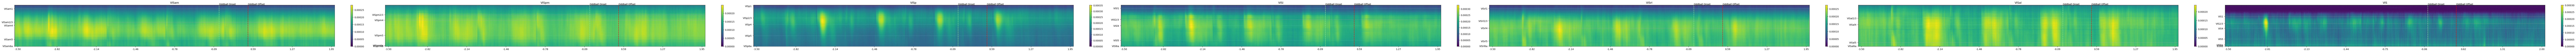

INFO:root:Plotted grand-variance LFPs for condition go_gloexp


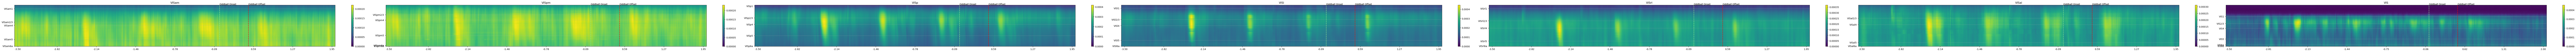

INFO:root:Plotted grand-variance LFPs for condition go_seqctl


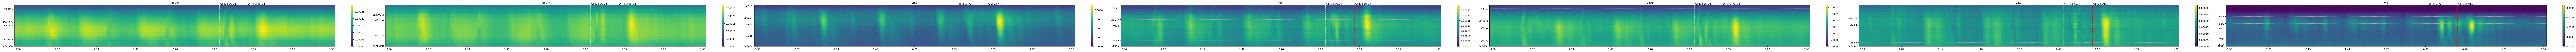

INFO:root:Plotted grand-variance LFPs for condition lo_gloexp


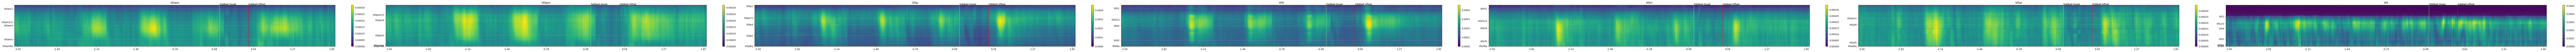

INFO:root:Plotted grand-variance LFPs for condition lo_rndctl


In [21]:
for cond in CONDITIONS:
    variances[cond] = epych.recording.EvokedSampling(epych.recording.empty_intervals(), epych.recording.empty_trials(), epych.recording.default_units(),
                                                     **{k: v.result() for k, v in summaries[cond].stats.items()})
    variances[cond].smap(lambda sig: sig.__class__(sig.channels, np.sqrt(sig.data), sig.dt, sig.times)).plot(vmin=0., figure="mice_passiveglo_visual_%s_lfp_variance.pdf" % cond, **events)
    logging.info("Plotted grand-variance LFPs for condition %s" % cond)